In [2]:
import cv2

In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.models as models

In [7]:
image_dir = "material_data/1"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [17]:
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

/home/aj3246/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aj3246/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/aj3246/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.9MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [18]:
model = model.to(device)

In [19]:
features = []
with torch.no_grad():
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)  # Send to GPU
        output = model(input_tensor).squeeze().cpu().numpy()   # Back to CPU for numpy
        features.append(output)

✅ Clustering complete. Plot saved as clusters.png


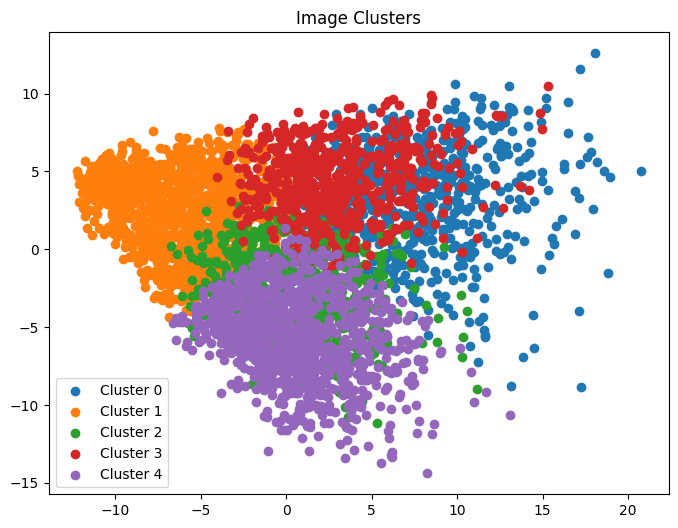

In [20]:
features = np.array(features)



# KMeans Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features)

# 2D visualization using PCA
vis = PCA(n_components=2).fit_transform(features)

# Plot and save
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    idx = np.where(labels == i)
    plt.scatter(vis[idx, 0], vis[idx, 1], label=f"Cluster {i}")
plt.legend()
plt.title("Image Clusters")
plt.savefig("clusters.png", dpi=300)
print("✅ Clustering complete. Plot saved as clusters.png")

In [21]:
import shutil

# Create cluster directories and move images
output_root = "clustered_images"
os.makedirs(output_root, exist_ok=True)

for i in range(n_clusters):
    cluster_folder = os.path.join(output_root, f"cluster_{i}")
    os.makedirs(cluster_folder, exist_ok=True)

for path, label in zip(image_paths, labels):
    filename = os.path.basename(path)
    dest_folder = os.path.join(output_root, f"cluster_{label}")
    shutil.copy2(path, os.path.join(dest_folder, filename))

print(f"✅ Images copied into cluster folders inside '{output_root}/'")

✅ Images copied into cluster folders inside 'clustered_images/'


In [22]:
import os
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [23]:
data_dir = "clustered_images"
batch_size = 16
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset and loader
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model setup: ResNet18 with modified classifier
model = models.resnet18(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/home/aj3246/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aj3246/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")

print("✅ Training complete!")


Epoch 1/5 - Loss: 265.5543
Epoch 2/5 - Loss: 183.8352
Epoch 3/5 - Loss: 144.1611
Epoch 4/5 - Loss: 112.1331
Epoch 5/5 - Loss: 87.8790
✅ Training complete!


In [26]:
# Save model
torch.save(model.state_dict(), "cluster_classifier.pth")
print("✅ Model saved as cluster_classifier.pth")

✅ Model saved as cluster_classifier.pth


In [32]:
# save_torchscript_model.py

import torch
from torchvision import models

# Same model definition as during training
num_classes = 5  # or however many clusters you had
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("cluster_classifier.pth"))
model.eval()

# Example input for tracing
example_input = torch.randn(1, 3, 224, 224)

# Convert to TorchScript
traced_model = torch.jit.trace(model, example_input)

# Save TorchScript model
traced_model.save("model.pt")
print("✅ TorchScript model saved!")


✅ TorchScript model saved!


In [33]:
print(traced_model.graph)

graph(%self.1 : __torch__.torchvision.models.resnet.___torch_mangle_738.ResNet,
      %x.1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu)):
  %fc : __torch__.torch.nn.modules.linear.___torch_mangle_737.Linear = prim::GetAttr[name="fc"](%self.1)
  %avgpool : __torch__.torch.nn.modules.pooling.___torch_mangle_736.AdaptiveAvgPool2d = prim::GetAttr[name="avgpool"](%self.1)
  %layer4 : __torch__.torch.nn.modules.container.___torch_mangle_735.Sequential = prim::GetAttr[name="layer4"](%self.1)
  %layer3 : __torch__.torch.nn.modules.container.___torch_mangle_719.Sequential = prim::GetAttr[name="layer3"](%self.1)
  %layer2 : __torch__.torch.nn.modules.container.___torch_mangle_703.Sequential = prim::GetAttr[name="layer2"](%self.1)
  %layer1 : __torch__.torch.nn.modules.container.___torch_mangle_687.Sequential = prim::GetAttr[name="layer1"](%self.1)
  %maxpool : __torch__.torch.nn.modules.pooling.___torch_mangle_674.MaxPool2d = prim::GetAttr[name="maxpool"]